# ECE 470 - Final Project
## Group Members: Andy Guevara - V00951198
## Handwritten Character Recognition Using Convolutional Neural Networks

---


Import required libraries and set up GPU.

In [ ]:
import sys
import tensorflow as tf
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

import tensorflow.compat.v2 as tf

import tensorflow_datasets.public_api as tfds

print('-'*40)
print ('Python version: {}'.format(sys.version))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

----------------------------------------
Python version: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Found GPU at: /device:GPU:0


Loading EMNIST Dataset from Tensorflow.

In [ ]:
(emnist_train, emnist_test), ds_info = tfds.load('emnist', 
                                                 split = ['train', 'test'], 
                                                 shuffle_files=True, 
                                                 as_supervised=True, 
                                                 with_info=True) #change as supervised if examples needed
#assert isinstance(emnist_train, tf.data.Dataset)
print(ds_info)

tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
    }),
    total_num_examples=814255,
    splits={
        'test': 116323,
        'train': 697932,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{cohen_afshar_tapson_schaik_2017,
        title={EMNIST: Extending MNIST to handwritten lett

Normalize images, and prepare dataloader.

In [ ]:
def normalize_img(img, label):
  return tf.cast(img, tf.float32)/255.0,label

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
emnist_train = emnist_train.map(normalize_img, num_parallel_calls = AUTOTUNE)
emnist_train = emnist_train.cache()
emnist_train = emnist_train.shuffle(ds_info.splits['train'].num_examples)
emnist_train = emnist_train.batch(BATCH_SIZE)
emnist_train = emnist_train.prefetch(AUTOTUNE)

emnist_test = emnist_test.map(normalize_img, num_parallel_calls = AUTOTUNE)
emnist_test = emnist_test.batch(BATCH_SIZE)
emnist_test = emnist_test.cache()
emnist_test = emnist_test.prefetch(AUTOTUNE)

Building, compile and fit model.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5,5), 
                        input_shape = (28,28,1), activation = 'relu', 
                        strides = (1,1))) #32 output channels
model.add(layers.Conv2D(64, (3,3), activation='relu', strides = (1,1)))

model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(62, activation='softmax'))



model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

model.summary()

MCP = ModelCheckpoint('Best_points.h5',verbose=1,
                      save_best_only=True,
                      monitor='accuracy',mode='max')
ES = EarlyStopping(monitor='accuracy',min_delta=0,
                   verbose=0,restore_best_weights = True,
                   patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.2,min_lr=0.0001)

history = model.fit(emnist_train, epochs = 45, callbacks=[MCP,ES,RLP])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               3965440   
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 62)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


10906/10906 [==============================] - 58s 5ms/step - loss: 0.4570 - accuracy: 0.8401

Epoch 00001: accuracy improved from -inf to 0.84006, saving model to Best_points.h5
Epoch 2/45
10906/10906 [==============================] - 58s 5ms/step - loss: 0.3593 - accuracy: 0.8662

Epoch 00002: accuracy improved from 0.84006 to 0.86624, saving model to Best_points.h5
Epoch 3/45
10906/10906 [==============================] - 59s 5ms/step - loss: 0.3277 - accuracy: 0.8750

Epoch 00003: accuracy improved from 0.86624 to 0.87500, saving model to Best_points.h5
Epoch 4/45
10906/10906 [==============================] - 58s 5ms/step - loss: 0.3024 - accuracy: 0.8823

Epoch 00004: accuracy improved from 0.87500 to 0.88233, saving model to Best_points.h5
Epoch 5/45
10906/10906 [==============================] - 58s 5ms/step - loss: 0.2799 - accuracy: 0.8893

Epoch 00005: accuracy improved from 0.88233 to 0.88931, saving model to Best_points.h5
Epoch 6/45
10906/10906 [=========================

Evaluate model.

In [ ]:
model.evaluate(emnist_test)

  37/1818 [..............................] - ETA: 5s - loss: 2.8938 - accuracy: 0.8433

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


1818/1818 [==============================] - 5s 3ms/step - loss: 2.9877 - accuracy: 0.8400


[2.987718105316162, 0.8399542570114136]

Display training results.

Text(0, 0.5, 'Accuracy')

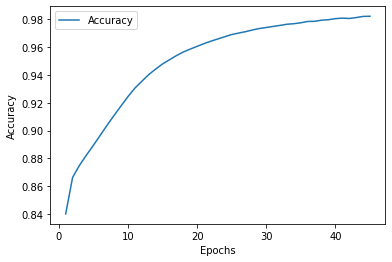

In [ ]:
q = len(history.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')